# Viewing the Processor Interaction

In this notebook, we will show how to visualize the timing for the interaction between the Vitis IP and processor.  Before running the notebook, you should complete the steps for [running the RTL simulation](https://sdrangan.github.io/hwdesign/scalar_fun/rtlsim.html).  This step will create a [**Value Change Dump**](https://en.wikipedia.org/wiki/Value_change_dump)  or **VCD** file with the values for all the signals between the IP and processor.


## Parsing the VCD file


First we import the relevant packages.

In [1]:
from vcdvcd import VCDVCD
import matplotlib.pyplot as plt

We parse the VCD file using the `VCDVCD` package.  The parsed data is in the `vcd` object.

In [84]:
# Check if VCD file exists
import os
fn = os.path.join(os.getcwd(), '..', 'scalar_fun_vitis', 'vcd', 'dump.vcd')
if not os.path.exists(fn):
    raise FileNotFoundError(f"VCD file not found: {fn}")

# Parse the VCD file
vcd = VCDVCD(fn, signals=None, store_tvs=True)




The RTL simulation records traces for a large number of signals.  You can get a full list with the following command.  You will see that there are over 200 such signals.

In [85]:
nsig = len(vcd.signals)
print(f"Number of signals in VCD: {nsig}")
print(vcd.signals[:5])


Number of signals in VCD: 284
['apatb_simp_fun_top.AESL_clock', 'apatb_simp_fun_top.rst', 'apatb_simp_fun_top.dut_rst', 'apatb_simp_fun_top.start', 'apatb_simp_fun_top.ce']


## Plotting a Timing Diagram

To visualize the interaction between the processor and IP, it is useful to create a **timing diagram**.  For this purpose, I have created a class, `VCDViewer` in the package `xilinxutils` that is part of the course repository.  We can import the package as follows.

In [86]:
import importlib

import xilinxutils
import xilinxutils.vcd
importlib.reload(xilinxutils)
importlib.reload(xilinxutils.vcd)
from xilinxutils.vcd import VcdParser
from xilinxutils.timing import TimingDiagram

The following code:
* Creates a viewing class
* Adds the **status signals** such as `start`, `idle` that tell when the IP should execute.
* Adds the **S-AXI-Lite signals** for the interface for the processor to read and write to the Vitis IP.
* Creates the timing diagram for the signals.


In [92]:
# Create a viewing class
vp = VcdParser(vcd)

# Add status and S-AXI-Lite signals
vp.add_status_signals()
vp.add_signals_prefix(prefix='s_axi_ctrl')



Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_AWVALID as AWVALID
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_AWREADY as AWREADY
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_AWADDR[5:0] as AWADDR[5:0]
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_WVALID as WVALID
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_WREADY as WREADY
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_WDATA[31:0] as WDATA[31:0]
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_WSTRB[3:0] as WSTRB[3:0]
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_ARVALID as ARVALID
Added signal with prefix 's_axi_ctrl': apatb_simp_fun_top.AESL_inst_simp_fun.s_axi_CTRL_ARREADY as ARREADY
Added signal with p

We can see the various phases of the **execution model**:

* The testbench first writes the two inputs to the IP:
    * Write  `WDATA = 7` and `5` to addresses `AWADDR = 16` and `24`
* Starts execution with `start=1`
* IP completes execution with strobing `done=1`
* Testbench reads the result `RDATA=12` from read address `ARADDR = 32`.

In [93]:
# Format data and address signals as hex
snames = ['ARADDR', 'AWADDR', 'RDATA', 'WDATA']
for s in vp.sig_info:
    short_name = vp.sig_info[s].short_name
    for sn in snames:
        if sn in short_name:
            vp.sig_info[s].numeric_fmt_str = '%x'
            vp.sig_info[s].numeric_type = 'uint'



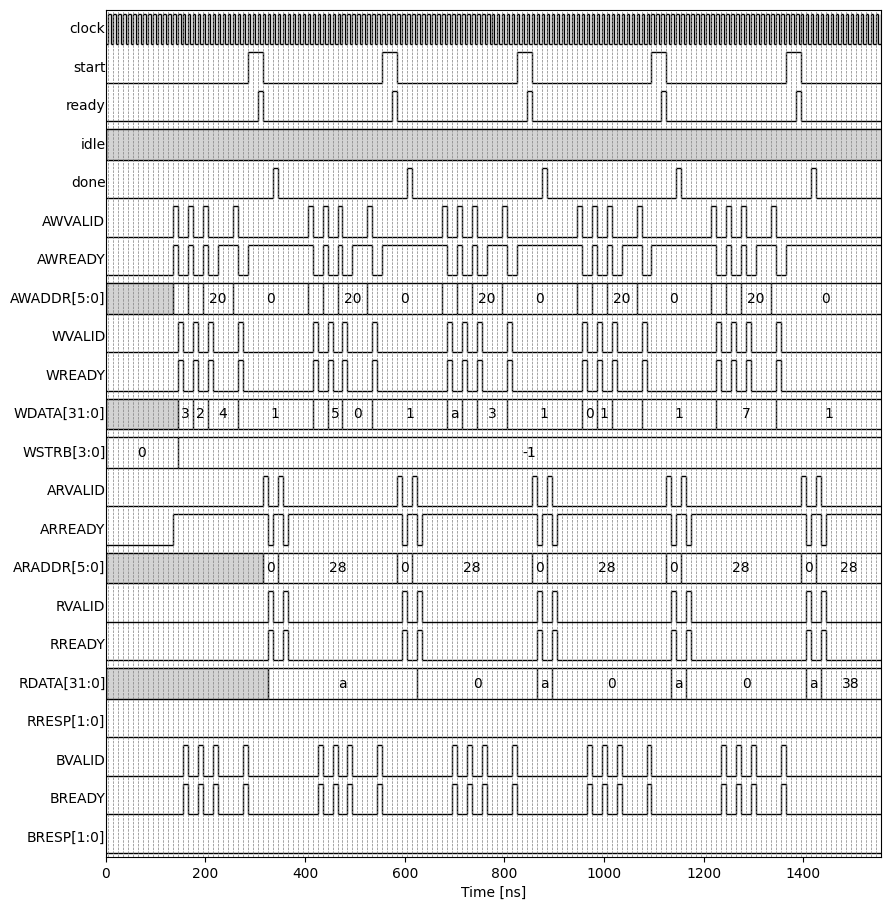

In [96]:
# Get the timing signals
sig_list = vp.get_td_signals()

# Create the timing diagram
td = TimingDiagram()
td.add_signals(sig_list)
trange = [100,400]
trange = None
ax = td.plot_signals(add_clk_grid=True, trange=trange, text_mode='auto', text_scale_factor=10)
_ = ax.set_xlabel('Time [ns]')

False
